## Ex. 2: Fetching fire weather data and displaying it on a map

This example demonstrates calling the API to obtain the latest temperature data for a certain state and displaying it on a map.

##### Libraries Used:
- json
- urllib
- matplotlib
- CartoPy

### To begin this example, we first need to decide our spatial context. 
Do we have an explicit list of stations? Networks? Maybe we want to query by a radius or a bounding box? Let's explore these different domains for a second. 

For this example, let's target only RAWS stations in a radius around a particular active fire in Tennessee called the Halls Top Fire for wind speed, humidity, and temperature in the last 2 hours. This query looks like:
http://api.mesowest.net/v2/stations/latest?&radius=35.874,-83.168,60&network=2&within=60&token=demotoken&vars=air_temp,wind_speed,relative_humidity&units=english

### Again, we'll use urllib and json to take care of the request for us and make it a JSON object.

In [1]:
import urllib.request
import json

q = 'http://api.mesowest.net/v2/stations/latest?&radius=35.874,-83.168,60&network=2&within=60&token=demotoken&vars=air_temp,wind_speed,relative_humidity&units=english'
# Open the url and read the contents
resp = urllib.request.urlopen(q).read()
# Decode and make the content a JSON object
stationJSON = json.loads(resp.decode('utf-8'))

### When we inspect the dataset, we discover many stations that meet our criteria. Awesome!

In [3]:
# stationJSON

### Now that we have the data, let's extract only the items we need for our map display. 
So we'll need the station ID, temperature, wind speed, and relative humidity for all stations. In python, a quick list generation tactic called a list comprehension makes this easy for us. 

In [4]:
stations = [[station['STID'], float(station['LATITUDE']), float(station['LONGITUDE']), 
             float(station['OBSERVATIONS']['air_temp_value_1']['value']), 
             float(station['OBSERVATIONS']['wind_speed_value_1']['value']), 
             float(station['OBSERVATIONS']['relative_humidity_value_1']['value'])] for station in stationJSON['STATION']]
# stations

Knowing the structure of the JSON response is crucial when dealing with nested dictionaries. In the above, we know all stations returned from the API are within the 'STATION' key as a list, so we can iterate over that to get each station. Then we know STID, latitude, and longitude are at the top level, while the observation variables require a little digging in the nested observation dictionary. 

### Now that our data is arranged, let's get to plotting!
Since we're concerned with fire, it would be nice to get a terrain map. This would be especially beneficial in the Smokies, where meteorological conditions may vary greatly because of elevation. Fortunately, CartoPy makes it easy to grab map tiles from MapQuest.

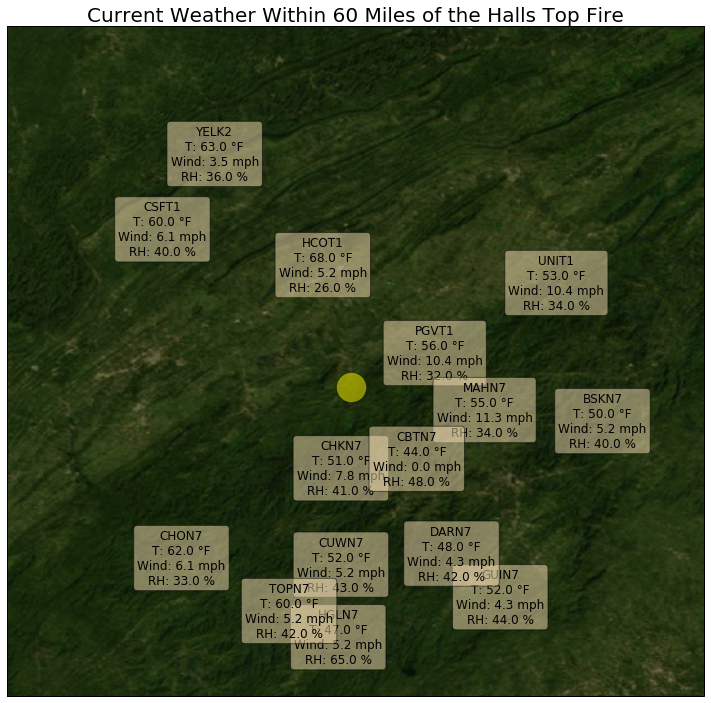

In [5]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
%matplotlib inline

# Create a new matplotlib figure
fig = plt.figure(figsize=(15,12))

# Create a MapQuest open aerial images instance
mapquest_aerial = cimgt.MapQuestOpenAerial()

# Create a geoaxis that matches the same projection as the map tiles
ax = plt.axes(projection=mapquest_aerial.crs)

# Limit the extent of the map to an area around the fire, this part requires some fiddlin'
ax.set_extent([-84.5, -81.8, 34.9, 37])

# Add the MapQuest tiles to the axis at zoom level 8
ax.add_image(mapquest_aerial, 8)

# Transforms for the text func we're about to call
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=0, y=0)

# Plot lat/long pts with below params
for stid, lat, lon, temp, wind, rh in stations:
    plt.plot(lon, lat, marker='o', color='y', markersize=1,
             alpha=0.7, transform=ccrs.Geodetic())
# Plot temp and station id for each of the markers
    textbox = stid + '\n' + 'T: ' + str(round(temp, 1)) + u' \N{DEGREE SIGN}' + 'F' + '\n'+ \
    'Wind: '+ str(round(wind, 1)) + ' mph' + '\n' + 'RH: ' + str(round(rh, 1)) + u' \N{PERCENT SIGN}'
    plt.text(lon, lat, textbox,
             verticalalignment='center', horizontalalignment='center',
             transform=text_transform, fontsize=12,
             bbox=dict(facecolor='wheat', alpha=0.5, boxstyle='round'))

plt.plot(-83.168, 35.874, marker='o', color='y', markersize=30,
         alpha=0.7, transform=ccrs.Geodetic())
    
plt.title('Current Weather Within 60 Miles of the Halls Top Fire', fontsize=20)